In [2]:
!pip install -U veux opensees numpy
#steel01, steel02, concretee02, concrete04

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 19.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.4/401.4 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 18.9 MB/s eta 0:00:00
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 

In [3]:
! pip show opensees

Name: opensees
Version: 0.1.17
Summary: Nonlinear finite element analysis.
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, platformdirs, prompt_toolkit, pygments, pyparsing, shps
Required-by: quakeio, sees, veux, xara, xsection


In [15]:
import veux
import numpy as np
import matplotlib.pyplot as plt
import opensees.openseespy as ops
from opensees.units.english import ksi, psi, inch, kip

ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)

In [11]:
def create_frame_2_steel(material):
    model = ops.Model('Basic', '-ndm', 2, ndf=3)

    # Define nodes
    coords = [
        (1, 0.0, 0.0), (2, 120.0, 0.0), (3, 240.0, 0.0),
        (4, 360.0, 0.0), (5, 480.0, 0.0), (6, 600.0, 0.0),
        (7, 0.0, 120.0), (8, 120.0, 120.0), (9, 240.0, 120.0),
        (10, 360.0, 120.0), (11, 480.0, 120.0), (12, 600.0, 120.0)
    ]
    for tag, x, y in coords:
        model.node(tag, x * inch, y * inch)

    # Fix all bottom nodes
    for i in range(1, 7):
        model.fix(i, (1, 1, 1))

    # Define transformation
    model.geomTransf('PDelta', 1)

    # Define material
    Fy = 50 * ksi
    E0 = 29000 * ksi
    b = 0.02
    R0 = 20
    R1 = 0.925
    R2 = 0.15

    if material == 'Steel01':
        mat_tag = 1
        model.uniaxialMaterial('Steel01', mat_tag, Fy, E0, b)
    elif material == 'Steel02':
        mat_tag = 2
        model.uniaxialMaterial('Steel02', mat_tag, Fy, E0, b, R0, R1, R2)
    else:
        raise ValueError("Invalid material. Choose 'Steel01' or 'Steel02'.")

    # Define cross-section and section
    side = 4 * inch
    model.section('Fiber', 1)
    model.fiber(-side/2, -side/2, 0.01, mat_tag, section=1)
    model.fiber(side/2, -side/2, 0.01, mat_tag, section=1)
    model.fiber(-side/2, side/2, 0.01, mat_tag, section=1)
    model.fiber(side/2, side/2, 0.01, mat_tag, section=1)

    model.beamIntegration('Lobatto', 1, 1, 4)

    # Define columns
    for i in range(6):
        model.element('forceBeamColumn', i + 1, (i + 1, i + 7), 1, 1, 'iter', 30, 1e-12)

    # Define beams
    for i in range(5):
        model.element('forceBeamColumn', i + 7, (i + 7, i + 8), 1, 1, 'iter', 30, 1e-12)

    # Define truss elements
    side_truss = 2 * inch
    A_truss = side_truss ** 2
    truss_conns = [
        (1, 8), (2, 7), (2, 9), (3, 8), (3, 10), (4, 9),
        (4, 11), (5, 10), (5, 12), (6, 11)
    ]
    for i, (n1, n2) in enumerate(truss_conns):
        model.element('truss', 12 + i, (n1, n2), A_truss, mat_tag)

    return model

In [6]:
#visualize the model
#model=create_frame_2_steel('Steel01')
#veux.render(model)

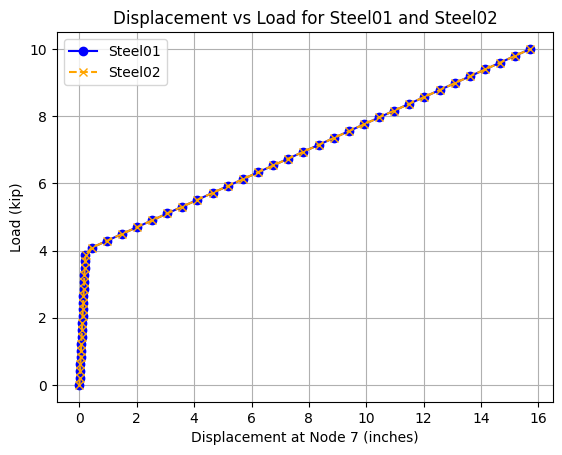

In [12]:

import matplotlib.pyplot as plt
import numpy as np



# Modified uprime function that takes a load as an argument
def uprime(load, material):
    model = create_frame_2_steel(material=material)
    model.pattern("Plain", 2, "Linear")
    model.load(7, load, 0, 0)
    model.algorithm("Newton")
    model.integrator("LoadControl", 1)
    model.analysis("Static")
    model.analyze(1)
    return model.nodeDisp(7, 1)

# Generate 50 loads from 0 to 4 kips
loads_kip = np.linspace(0, 10, 50)
loads = [l * kip for l in loads_kip]  # Convert to internal units


# Define materials and their styles
material_styles = {
    'Steel01': {'color': 'blue', 'linestyle': '-', 'marker': 'o'},
    'Steel02': {'color': 'orange', 'linestyle': '--', 'marker': 'x'}
}

# Plot for both materials
for material, style in material_styles.items():
    displacements = []
    for load in loads:
        u = uprime(load, material)
        displacements.append(u)
    plt.plot(displacements, loads_kip,
             label=material,
             color=style['color'],
             linestyle=style['linestyle'],
             marker=style['marker'])

# Add labels and legend
plt.xlabel('Displacement at Node 7 (inches)')
plt.ylabel('Load (kip)')
plt.title('Displacement vs Load for Steel01 and Steel02')
plt.legend()
plt.grid(True)
plt.show()


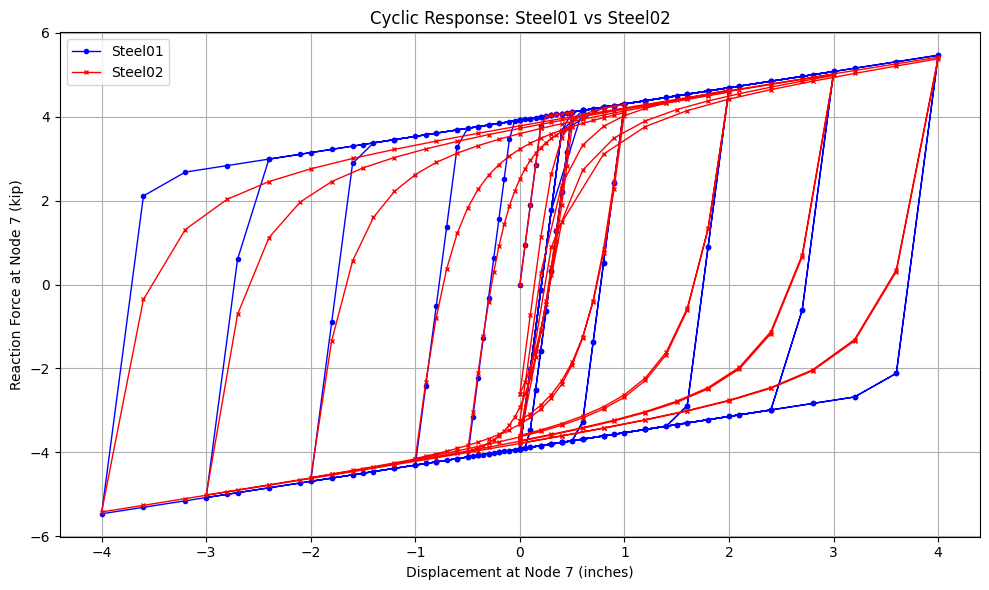

In [13]:



# Your existing model creation function should be defined here
# (Assuming you've already pasted the corrected `create_frame_2_steel(material)`)

# Generate a richer displacement history
def generate_history(max_disp=4.0*inch, steps_per_cycle=10):
    disp_inch = []
    for amp in [ 0.5*inch, 1.0*inch, 2.0*inch, 3.0*inch, max_disp]:
        step = amp / steps_per_cycle
        cycle = (
            list(np.arange(0, amp + step, step)) +
            list(np.arange(amp - step, -amp - step, -step)) +
            list(np.arange(-amp + step, amp + step, step)) +
            list(np.arange(amp - step, 0 - step, -step))
)
        disp_inch.extend(cycle)
    return disp_inch

# Updated analysis function
def analyze_history_displacement(model, displacement_history, dof=1):
    u_displacement_history = []
    force_displacement_history = []

    model.constraints("Plain")
    model.numberer("Plain")
    model.system("BandGeneral")
    model.test("NormUnbalance", 1e-6, 10)
    model.algorithm("Newton")
    model.analysis("Static")

    current_disp = 0.0
    for target_disp in displacement_history:
        disp_increment = target_disp - current_disp
        model.integrator("DisplacementControl", 7, dof, disp_increment)
        ok = model.analyze(1)
        if ok != 0:
            print(f"Step failed at target {target_disp:.3f} inches")
            break
        u = model.nodeDisp(7, dof)
        r = model.getTime()
        u_displacement_history.append(u)
        force_displacement_history.append(r)
        current_disp = target_disp

    return u_displacement_history, force_displacement_history

# Run for Steel01
ops.wipe()
model_steel01 = create_frame_2_steel('Steel01')
model_steel01.pattern("Plain", 3, "Linear")
model_steel01.load(7, 1 * kip, 0, 0)

history = generate_history()
u01, f01 = analyze_history_displacement(model_steel01, history)

# Run for Steel02
ops.wipe()
model_steel02 = create_frame_2_steel('Steel02')
model_steel02.pattern("Plain", 3, "Linear")
model_steel02.load(7, 1 * kip, 0, 0)

u02, f02 = analyze_history_displacement(model_steel02, history)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(u01, f01, label='Steel01', color='blue', marker='o', markersize=3, linewidth=1)
plt.plot(u02, f02, label='Steel02', color='red', marker='x', markersize=3, linewidth=1)
plt.xlabel('Displacement at Node 7 (inches)')
plt.ylabel('Reaction Force at Node 7 (kip)')
plt.title('Cyclic Response: Steel01 vs Steel02')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()